In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import os

In [2]:
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import clear_session



In [3]:
train_path = "/kaggle/input/brain-tumor-classification-mri/Training"
test_path = "/kaggle/input/brain-tumor-classification-mri/Testing"

In [4]:
folds=os.listdir(train_path)
file=[]
label=[]
for fold in folds:
    file_path=os.path.join(train_path,fold)
    images=os.listdir(file_path)
    
    for image in images:
        file.append(os.path.join(file_path,image))
        label.append(fold)
        

files=pd.Series(file)
labels=pd.Series(label)

train_data=pd.concat([files,labels],axis=1)
train_df=pd.DataFrame(train_data)
train_df.columns=['file','label']

In [5]:
file=[]
label=[]
folds=os.listdir(test_path)
for fold in folds:
    file_path=os.path.join(test_path,fold)
    images=os.listdir(file_path)
    
    for image in images:
        file.append(os.path.join(file_path,image))
        label.append(fold)
        

files=pd.Series(file)
labels=pd.Series(label)

test_data=pd.concat([files,labels],axis=1)
test_df=pd.DataFrame(test_data)
test_df.columns=['file','label']

In [6]:
train_df,validation_df = train_test_split(train_df,test_size=0.2,random_state=42,shuffle=True)

In [7]:
generator=ImageDataGenerator()

def create_dataset(df, shuffle = False):
    return generator.flow_from_dataframe(df, class_mode="categorical",x_col='file',y_col='label',shuffle=shuffle)

train_dataset = create_dataset(train_df,shuffle=True) 
valid_dataset = create_dataset(validation_df)
test_dataset = create_dataset(test_df)

Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


In [8]:
label_dict = train_dataset.class_indices
tumor_type = list(label_dict.keys())
images,labels=next(train_dataset)

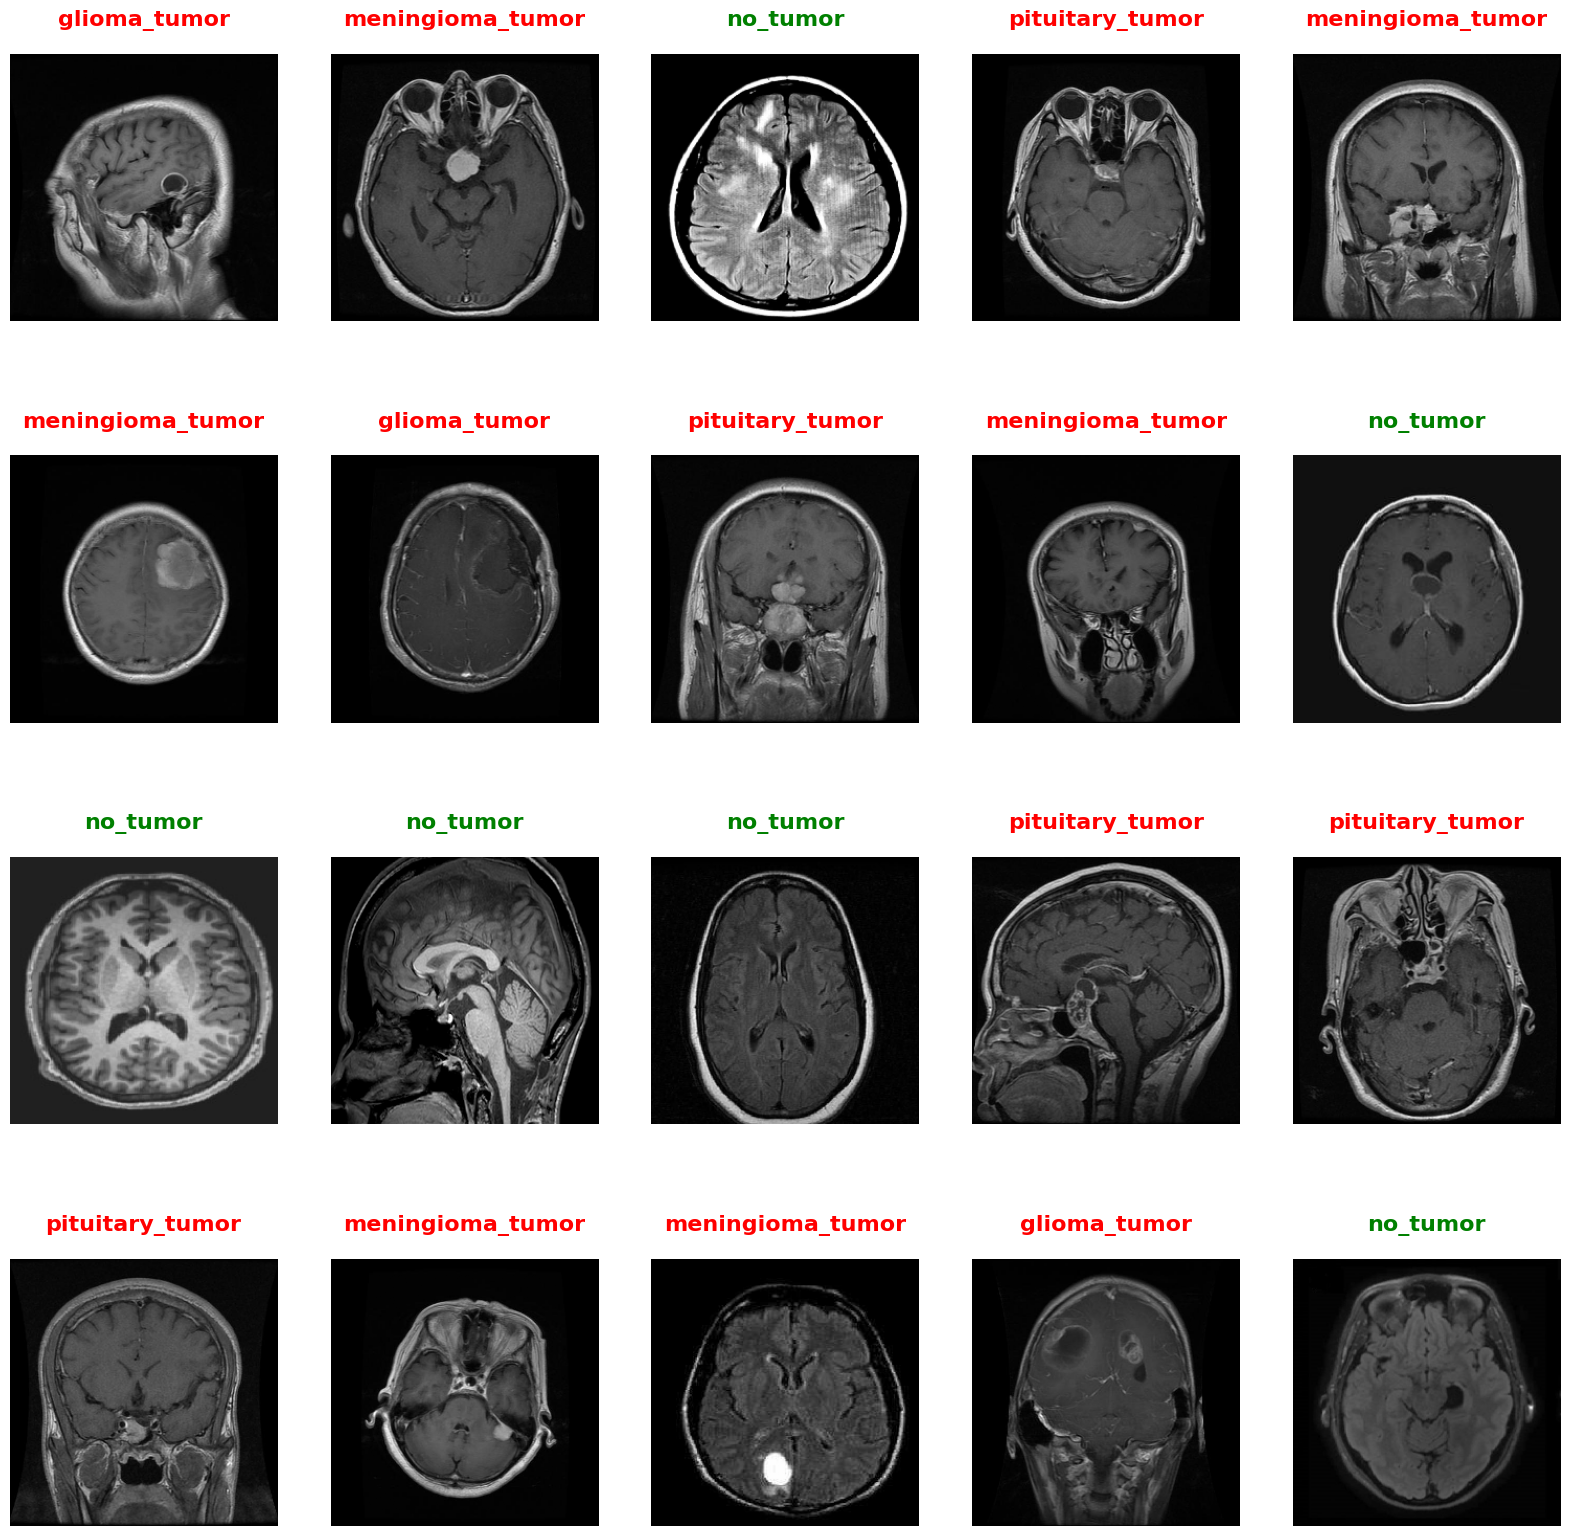

In [9]:
from matplotlib import rcParams

plt.figure(figsize= (20,20))
rcParams['axes.titlepad'] = 20

for i in range(20):
    plt.subplot(4,5,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    tumor_type_name = tumor_type[index]
    color = 'green' if tumor_type_name == 'no_tumor' else 'red'
    plt.title(tumor_type_name, fontsize=16, fontweight='bold', color=color)
    plt.axis('off')

plt.show()

In [ ]:
# Fixing the seed for random number generators
import random
clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Hyperparamter Tuning using Optuna

In [11]:
"""import optuna


def create_model(trial):
   effnetb3_model= EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='max',
    classifier_activation="softmax")
    
    for layer in effnetb3_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(effnetb3_model)
    model.add(BatchNormalization(axis=-1, momentum=0.016))

    # Hyperparameters to tune
    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    l1_value = trial.suggest_float('l1_reg', 1e-5, 1e-2, log=True)

    for i in range(num_dense_layers):
        num_units = trial.suggest_int('num_units_l{}'.format(i), 64, 1024, log=True)
        model.add(Dense(num_units,kernel_regularizer=regularizers.l1(l1_value), activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(4, activation='softmax'))

    optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def objective(trial):
    model = create_model(trial)
    early_stop = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(train_dataset, 
                        epochs=1, 
                        validation_data=valid_dataset,
                        callbacks=[early_stop],
                        verbose=1)  # Set verbose=0 to hide output
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

print("Best hyperparameters: ", study.best_trial.params)"""

'import optuna\n\n\ndef create_model(trial):\n   effnetb3_model= EfficientNetB3(\n    include_top=False,\n    weights="imagenet",\n    input_shape=(224,224,3),\n    pooling=\'max\',\n    classifier_activation="softmax")\n    \n    for layer in effnetb3_model.layers:\n        layer.trainable = False\n\n    model = Sequential()\n    model.add(effnetb3_model)\n    model.add(BatchNormalization(axis=-1, momentum=0.016))\n\n    # Hyperparameters to tune\n    num_dense_layers = trial.suggest_int(\'num_dense_layers\', 1, 5)\n    dropout_rate = trial.suggest_float(\'dropout_rate\', 0.1, 0.5)\n    learning_rate = trial.suggest_float(\'learning_rate\', 1e-5, 1e-1, log=True)\n    l1_value = trial.suggest_float(\'l1_reg\', 1e-5, 1e-2, log=True)\n\n    for i in range(num_dense_layers):\n        num_units = trial.suggest_int(\'num_units_l{}\'.format(i), 64, 1024, log=True)\n        model.add(Dense(num_units,kernel_regularizer=regularizers.l1(l1_value), activation=\'relu\'))\n        model.add(Dropout

**Best Hyperparameters according to Optuna:**

* num_dense_layers': 1
* dropout_rate: 0.24377169383011632
* learning_rate: 0.008853510984551376
* l1_reg: 0.00016219569284178702
* num_units_l0: 432



In [12]:
effnetb3_model=EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='max',
    classifier_activation="softmax",
)

for layer in effnetb3_model.layers:
    layer.trainable = False
    
model = Sequential()

model.add(effnetb3_model)
model.add(BatchNormalization(axis=-1, momentum=0.016))
model.add(Dense(432, kernel_regularizer=regularizers.l1(0.00016219569284178702), activation='relu'))
model.add(Dropout(0.24377169383011632))

model.add(Dense(4, activation='softmax'))

43941136/43941136 [==============================] - 0s 0us/step


In [13]:
opt = SGD(learning_rate=0.008853510984551376, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 432)               663984    
                                                                 
 dropout (Dropout)           (None, 432)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1732      
                                                                 
Total params: 11455395 (43.70 MB)
Trainable params: 6687

In [14]:
model_checkpoint_filpath5 = "model_checkpoint.h5"
callbacks_checkpoints5 = ModelCheckpoint(

    filepath = model_checkpoint_filpath5,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [15]:
history = model.fit(train_dataset,
                    epochs = 20,
                    validation_data = valid_dataset,
                    callbacks = [callbacks_checkpoints5]
                    )

Epoch 1/20
72/72 [==============================] - 331s 4s/step - loss: 3.7014 - accuracy: 0.7239 - val_loss: 3.2390 - val_accuracy: 0.8763
Epoch 2/20
72/72 [==============================] - 315s 4s/step - loss: 3.2006 - accuracy: 0.8711 - val_loss: 3.1181 - val_accuracy: 0.8815
Epoch 3/20
72/72 [==============================] - 335s 5s/step - loss: 2.9838 - accuracy: 0.9168 - val_loss: 2.9870 - val_accuracy: 0.8920
Epoch 4/20
72/72 [==============================] - 334s 5s/step - loss: 2.8313 - accuracy: 0.9268 - val_loss: 2.8956 - val_accuracy: 0.9024
Epoch 5/20
72/72 [==============================] - 334s 5s/step - loss: 2.7431 - accuracy: 0.9329 - val_loss: 2.8326 - val_accuracy: 0.8868
Epoch 6/20
72/72 [==============================] - 307s 4s/step - loss: 2.6159 - accuracy: 0.9390 - val_loss: 2.6652 - val_accuracy: 0.9146
Epoch 7/20
72/72 [==============================] - 330s 5s/step - loss: 2.4902 - accuracy: 0.9508 - val_loss: 2.5847 - val_accuracy: 0.9199
Epoch 8/20
72

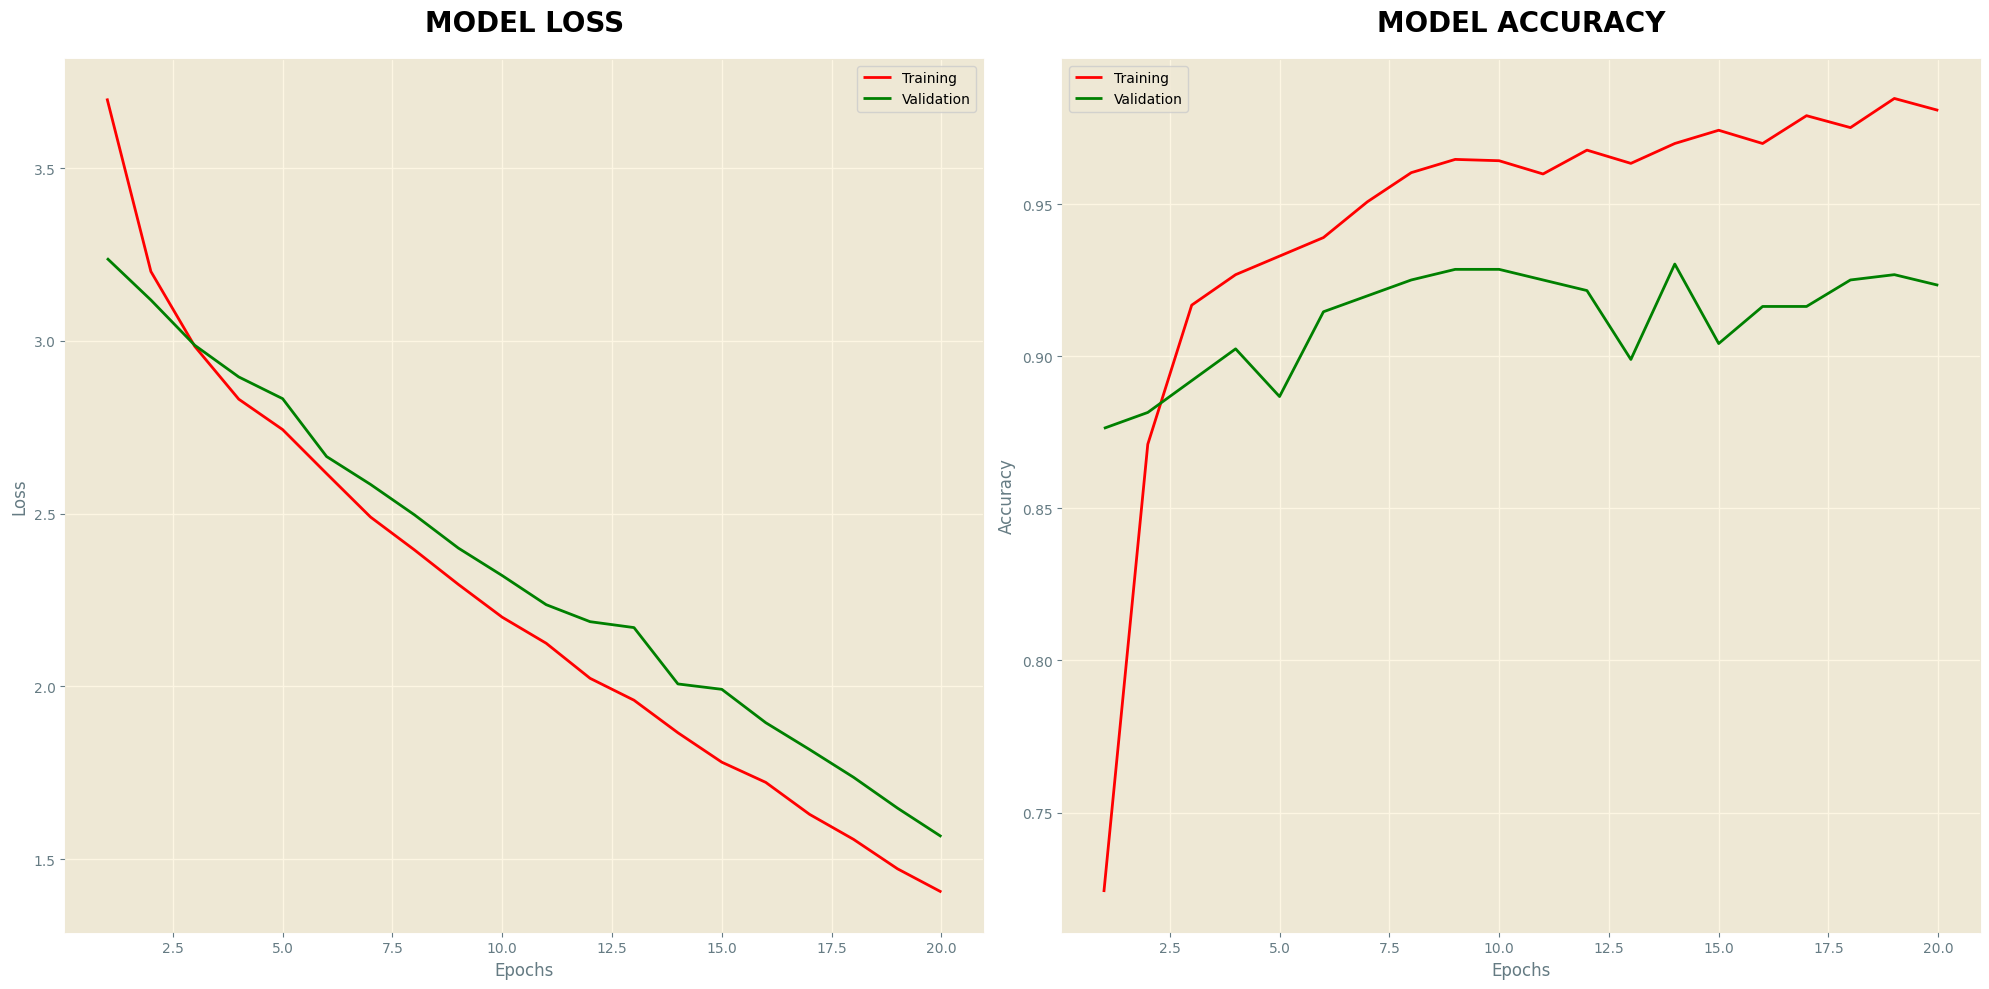

In [16]:
# Extracting accuracy and loss from the training history
train_acc, train_loss = history.history['accuracy'], history.history['loss']
val_acc, val_loss = history.history['val_accuracy'], history.history['val_loss']


# Generating a sequence of epoch numbers
epochs = range(1, len(train_acc) + 1)

# Plotting training and validation loss
plt.figure(figsize=(20, 10))
plt.style.use('Solarize_Light2')

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'g', label='Validation')
plt.title('MODEL LOSS', fontsize= 20, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training')
plt.plot(epochs, val_acc, 'g', label='Validation')
plt.title('MODEL ACCURACY', fontsize= 20, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
train_score = model.evaluate(train_dataset , steps =10 , verbose = 1)
valid_score = model.evaluate(valid_dataset , steps = 10 , verbose = 1)
test_score = model.evaluate(test_dataset , steps = 10 , verbose = 1)

cnn_eval_dict = {
    'Evaluation': ['Loss', 'Accuracy'],
    'Training': [train_score[0], train_score[1]],
    'Testing': [test_score[0], test_score[1]],
    'Validation': [valid_score[0], valid_score[1]],

}

cnn_eval_df = pd.DataFrame(cnn_eval_dict)

10/10 [==============================] - 35s 3s/step - loss: 2.1872 - accuracy: 0.8781


In [19]:
cnn_eval_df

,Evaluation,Training,Testing,Validation
0,Loss,1.321361,2.187232,1.544808
1,Accuracy,1.000000,0.878125,0.909375


In [20]:
model.save('my_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
